# Fine-tune ViT (Encoder) + Transformer Decoder on CROHME

Notebook outline: setup, imports, dataset preparation (CROHME), preprocessing, tokenizer (char-level), model (ViT encoder + PyTorch Transformer decoder), training loop, evaluation, saving and pushing to Hugging Face Hub.

This notebook assumes you have the CROHME data locally (InkML/PNG and ground-truth LaTeX). It uses a simple char-level tokenizer for LaTeX labels which is often sufficient for math OCR tasks.

In [25]:
# 1) Install dependencies (run once)
# If you are using the project's venv you can run these in a cell or terminal.
# !pip install -q transformers datasets tokenizers sentencepiece torch torchvision timm albumentations wandb

In [16]:
# 2) Imports
import os
import json
from pathlib import Path
import random
import math
from glob import glob
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

from transformers import AutoFeatureExtractor, ViTModel

print('torch', torch.__version__)
print('transformers', __import__('transformers').__version__)

torch 2.8.0+cu126
transformers 4.55.4


## 3) Load / prepare CROHME dataset

This section shows example code to collect (image_path, latex_label) pairs. Adjust `DATA_DIR` to your local CROHME location.

In [17]:
# Update this path to where your CROHME data (images and labels) lives
DATA_DIR = Path('d:/projectDAT/image-computer/new_process/Data')  # adjust if needed

# Example: try to find a CSV with image paths and LaTeX labels (many preprocessed datasets provide this)
csv_paths = list(DATA_DIR.rglob('*.csv'))
csv_paths[:5]

[WindowsPath('d:/projectDAT/image-computer/new_process/Data/annotations.csv'),
 WindowsPath('d:/projectDAT/image-computer/new_process/Data/data.csv'),
 WindowsPath('d:/projectDAT/image-computer/new_process/Data/dataCombined.csv'),
 WindowsPath('d:/projectDAT/image-computer/new_process/Data/dataCombined_with_crohme.csv'),
 WindowsPath('d:/projectDAT/image-computer/new_process/Data/dataCombined_with_crohme_png.csv')]

In [18]:
# Load CROHME data from CSV and split by tag (train/test/val)
def load_crohme_pairs_by_tag(csv_path, img_dir):
    import csv
    train_pairs = []
    test_pairs = []
    val_pairs = []
    
    with open(csv_path, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for r in reader:
            # Only get CROHME data
            if r.get('data_source') == 'CROHME':
                inkml_path = r.get('path')  # This contains crohme2019/train/file.inkml
                latex = r.get('Latex')
                tag = r.get('tags', '').strip().lower()  # Get tag field
                
                if inkml_path and latex:
                    # Convert inkml path to png path
                    rel_path = inkml_path.replace('.inkml', '.png')
                    img_path = str(Path(img_dir.parent) / rel_path)
                    
                    if Path(img_path).exists():
                        pair = (img_path, latex)
                        # Split by tag
                        if tag == 'train':
                            train_pairs.append(pair)
                        elif tag == 'test':
                            test_pairs.append(pair)
                        elif tag == 'valid':
                            val_pairs.append(pair)
                        else:
                            # Default to train if tag is missing or unknown
                            train_pairs.append(pair)
    
    return train_pairs, test_pairs, val_pairs

# Load CROHME data and split by tags
csv_path = DATA_DIR / 'dataCombined_with_crohme_png.csv'
img_dir = DATA_DIR / 'crohme2019'
if csv_path.exists() and img_dir.exists():
    print('Loading CROHME data from', csv_path)
    train_pairs, test_pairs, val_pairs = load_crohme_pairs_by_tag(csv_path, img_dir)
    print(f'Found {len(train_pairs)} train pairs')
    print(f'Found {len(test_pairs)} test pairs')
    print(f'Found {len(val_pairs)} validation pairs')
    
    # Combine all for backward compatibility (can be removed later)
    pairs = train_pairs + test_pairs + val_pairs
    print(f'Total: {len(pairs)} CROHME image-latex pairs')
else:
    train_pairs, test_pairs, val_pairs = [], [], []
    pairs = []

len(pairs)

Loading CROHME data from d:\projectDAT\image-computer\new_process\Data\dataCombined_with_crohme_png.csv
Found 8900 train pairs
Found 1198 test pairs
Found 986 validation pairs
Total: 11084 CROHME image-latex pairs


11084

In [19]:
# Check that our image paths are valid
if pairs:
    print(f'Total pairs found: {len(pairs)}')
    print('\nFirst 3 pairs:')
    for img_path, latex in pairs[:3]:
        print(f'Image: {img_path}')
        print(f'LaTeX: {latex}')
        print(f'Image exists: {Path(img_path).exists()}\n')

Total pairs found: 11084

First 3 pairs:
Image: d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB2372.png
LaTeX: f Sup \prime NoRel ( Right x Right ) Right = NoRel 1 NoRel - Below 2 Right \sqrt Inside x
Image exists: True

Image: d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB3179.png
LaTeX: h Right ( Right x Right COMMA Right y Right ) Right = Right x Sup y Right + NoRel 1 NoRel - Below y
Image exists: True

Image: d:\projectDAT\image-computer\new_process\Data\crohme2019\train\200922-949-204.png
LaTeX: F Right f Right N
Image exists: True



In [20]:
# Check our LaTeX vocabulary
if pairs:
    # Ensure a tokenizer object exists. If not, create one (fallback).
    if 'tokenizer' not in globals():
        # If CharTokenizer class isn't defined yet in this notebook, define a minimal fallback.
        if 'CharTokenizer' not in globals():
            class CharTokenizer:
                def __init__(self, vocab=None):
                    if vocab is None:
                        self.vocab = {'<pad>':0, '<bos>':1, '<eos>':2, '<unk>':3}
                    else:
                        self.vocab = dict(vocab)
                    self.inv_vocab = {i:c for c,i in self.vocab.items()}
                def build_vocab(self, texts):
                    chars = set()
                    for t in texts:
                        chars.update(list(t))
                    idx = max(self.vocab.values()) + 1
                    for c in sorted(chars):
                        if c not in self.vocab:
                            self.vocab[c] = idx
                            idx += 1
                    self.inv_vocab = {i:c for c,i in self.vocab.items()}
                def encode(self, text, max_length=None):
                    ids = [self.vocab.get('<bos>')]
                    for c in text:
                        ids.append(self.vocab.get(c, self.vocab.get('<unk>')))
                    ids.append(self.vocab.get('<eos>'))
                    if max_length is not None:
                        ids = ids[:max_length]
                    return ids
                def decode(self, ids):
                    s = ''
                    for i in ids:
                        if i in (self.vocab['<bos>'], self.vocab['<eos>'], self.vocab['<pad>']):
                            continue
                        s += self.inv_vocab.get(i, '')
                    return s
        # instantiate tokenizer and build vocab from available labels if possible
        tokenizer = CharTokenizer()
        
        if 'labels' in globals() and labels:
            tokenizer.build_vocab(labels)

    print('Tokenizer vocabulary:')
    print(sorted(tokenizer.vocab.keys())[:20], '...')  # Show first 20 tokens

    print('\nSample encoded/decoded text:')
    _, latex = pairs[0]
    print('Original:', latex)
    ids = tokenizer.encode(latex)
    print('Encoded:', ids)
    print('Decoded:', tokenizer.decode(ids))

Tokenizer vocabulary:
['<bos>', '<eos>', '<pad>', '<unk>'] ...

Sample encoded/decoded text:
Original: f Sup \prime NoRel ( Right x Right ) Right = NoRel 1 NoRel - Below 2 Right \sqrt Inside x
Encoded: [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]
Decoded: <unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>


If you don't have a CSV, use any InkML-to-image conversion script (there is `inkml2img.py` in the repo) to render PNGs and then pair with ground-truth LaTeX files. The code below assumes `pairs` is a list of (image_path, latex_string).

0 d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB2372.png f Sup \prime NoRel ( Right x Right ) Right = NoRel 1 NoRel - Below 2 Right \sqrt Inside x


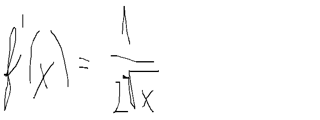

1 d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB3179.png h Right ( Right x Right COMMA Right y Right ) Right = Right x Sup y Right + NoRel 1 NoRel - Below y


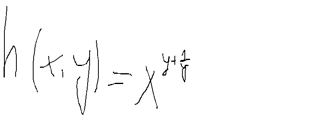

2 d:\projectDAT\image-computer\new_process\Data\crohme2019\train\200922-949-204.png F Right f Right N


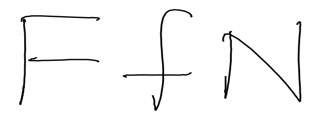

3 d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB1321.png x Sup 2 NoRel - Right x Right - Right 6 Right \lt Right 0


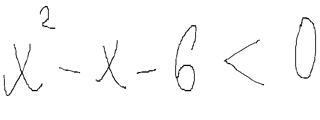

4 d:\projectDAT\image-computer\new_process\Data\crohme2019\train\MfrDB3271.png 3 Right a Sup 2 NoRel b Sup 3 NoRel + Right 5 Right a Sup 3 NoRel b Sup 2 NoRel - NoRel a Sup 5 NoRel b Sup 8 NoRel - Below 2


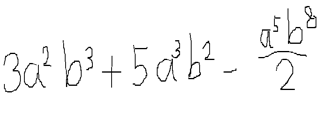

In [21]:
# Quick sanity check: show a few examples (if pairs exist)
if pairs:
    from IPython.display import display
    for i, (img_path, lab) in enumerate(pairs[:5]):
        print(i, img_path, lab)
        try:
            display(Image.open(img_path).convert('RGB').resize((320, 120)))
        except Exception as e:
            print('Could not open', img_path, e)
else:
    print('No (image,label) pairs found. Prepare your dataset first.')

## 4) Preprocessing (images and labels) and tokenizer

We'll use ViT feature extractor for images and a simple char-level tokenizer for LaTeX labels. For production, consider training a SentencePiece tokenizer on all labels.

In [22]:
# Load ViT feature extractor
from transformers import AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# Get the correct image size - feature_extractor.size returns a dict with 'height' and 'width'
image_size = feature_extractor.size['height'] if isinstance(feature_extractor.size, dict) else 224
print('feature extractor size', image_size) # Set to 384 for CROHME images
# Define image transform using feature_extractor if needed
def preprocess_image(path):
    img = Image.open(path).convert('RGB')
    # Resize while keeping aspect ratio and pad to square image_size
    w, h = img.size
    scale = min(image_size / w, image_size / h)
    new_w, new_h = int(w*scale), int(h*scale)
    img = img.resize((new_w, new_h), Image.BILINEAR)
    new_img = Image.new('RGB', (image_size, image_size), (255,255,255))
    new_img.paste(img, ((image_size-new_w)//2, (image_size-new_h)//2))
    arr = np.array(new_img).astype(np.float32)/255.0
    # normalize by ImageNet stats as ViT was trained on ImageNet-like data
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    arr = (arr - mean) / std
    # HWC -> CHW
    arr = np.transpose(arr, (2,0,1))
    return arr

# Simple char-level tokenizer for LaTeX labels with improved handling of special characters
class CharTokenizer:
    def __init__(self, vocab=None):
        if vocab is None:
            self.vocab = {'<pad>':0, '<bos>':1, '<eos>':2, '<unk>':3}
        else:
            self.vocab = dict(vocab)
        self.inv_vocab = {i:c for c,i in self.vocab.items()}
        
    def build_vocab(self, texts):
        chars = set()
        for t in texts:
            # Handle each character, including backslash
            i = 0
            while i < len(t):
                if t[i] == '\\' and i + 1 < len(t):
                    # Find the end of the LaTeX command
                    j = i + 1
                    while j < len(t) and t[j].isalpha():
                        j += 1
                    if j > i + 1:
                        # Add the entire LaTeX command as one token
                        chars.add(t[i:j])
                        i = j
                        continue
                chars.add(t[i])
                i += 1
                
        idx = max(self.vocab.values()) + 1
        for c in sorted(chars):
            if c not in self.vocab:
                self.vocab[c] = idx
                idx += 1
        self.inv_vocab = {i:c for c,i in self.vocab.items()}
        
    def encode(self, text, max_length=None):
        ids = [self.vocab.get('<bos>')]
        i = 0
        while i < len(text):
            if text[i] == '\\' and i + 1 < len(text):
                # Try to match LaTeX command
                j = i + 1
                while j < len(text) and text[j].isalpha():
                    j += 1
                if j > i + 1:
                    command = text[i:j]
                    ids.append(self.vocab.get(command, self.vocab.get('<unk>')))
                    i = j
                    continue
            ids.append(self.vocab.get(text[i], self.vocab.get('<unk>')))
            i += 1
        ids.append(self.vocab.get('<eos>'))
        if max_length is not None:
            ids = ids[:max_length]
        return ids
        
    def decode(self, ids):
        # remove special tokens and reconstruct text
        s = ''
        for i in ids:
            if i in (self.vocab['<bos>'], self.vocab['<eos>'], self.vocab['<pad>']):
                continue
            token = self.inv_vocab.get(i, '')
            s += token
        return s

# Build tokenizer on labels if pairs exist
tokenizer = CharTokenizer()
if pairs:
    labels = [lab for _, lab in pairs]
    tokenizer.build_vocab(labels)
    print('Vocab size', len(tokenizer.vocab))
else:
    print('No labels to build tokenizer; create tokenizer from a sample list manually')

[WARNING 2025-10-22 08:15:00,996 _showwarnmsg:110] d:\projectDAT\image-computer\new_process\venv\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
 


feature extractor size 224
Vocab size 107


In [23]:
# Vision Transformer Hybrid encoder (ResNet + ViT)
from transformers import ViTHybridModel, ViTModel
# Option 1: Use ViT Hybrid (ResNet backbone + Transformer)
# Option 2: Fallback to standard ViT if hybrid not available

use_hybrid = True  # Set to False to force standard ViT

if use_hybrid:
    try:
        # Try to load a pre-trained hybrid model
        # Available models:
        # - 'google/vit-hybrid-base-bit-384' (BiT-ResNetv2 + ViT, input 384x384)
        encoder = ViTHybridModel.from_pretrained('google/vit-hybrid-base-bit-384')
        print('✓ Loaded ViT Hybrid model: google/vit-hybrid-base-bit-384')
        print(f'  Hidden size: {encoder.config.hidden_size}')
        print(f'  Num layers: {encoder.config.num_hidden_layers}')
    except Exception as e:
        # Fallback to standard ViT if hybrid model not available
        print(f'✗ Could not load hybrid model: {e}')
        print('  Falling back to standard ViT...')
        encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        print('✓ Loaded standard ViT model')
else:
    encoder = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
    print('✓ Loaded standard ViT model')
encoder.eval()
print(f'\\nEncoder config:')
print(f'  Model type: {type(encoder).__name__}')
print(f'  Hidden size: {encoder.config.hidden_size}')
# Define seq2seq model combining ViT encoder + Transformer decoder,

Some weights of ViTHybridModel were not initialized from the model checkpoint at google/vit-hybrid-base-bit-384 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Loaded ViT Hybrid model: google/vit-hybrid-base-bit-384
  Hidden size: 768
  Num layers: 12
\nEncoder config:
  Model type: ViTHybridModel
  Hidden size: 768


## 5) Load ViT encoder and define seq2seq model (ViT encoder + Transformer decoder)

We will load ViTModel (no head) as encoder and create a Transformer decoder + linear head to predict tokens. This is a simple, trainable decoder from scratch.

### Vision Transformer Hybrid Options

ViT Hybrid combines CNN (ResNet) with Transformer for better feature extraction. Available options:

1. **`google/vit-hybrid-base-bit-384`** - BiT-ResNetv2 + ViT (384x384, more accurate)
2. **Standard ViT** - Pure transformer (fallback if hybrid not available)

**Advantages of Hybrid:**
- Better at capturing local features (from CNN)
- Better at capturing global features (from Transformer)
- Often better performance on complex images

**Trade-offs:**
- Larger model size
- Slower inference
- May require more training data

In [24]:

class ViTSeq2Seq(nn.Module):
    def __init__(self, encoder, vocab_size, d_model=768, nhead=8, num_decoder_layers=4, dim_feedforward=1024, dropout=0.1, max_len=256):
        super().__init__()
        self.encoder = encoder
        self.d_model = d_model
        self.vocab_size = vocab_size
        # linear proj for encoder outputs to transformer d_model if needed
        self.enc_proj = nn.Linear(encoder.config.hidden_size, d_model) if encoder.config.hidden_size != d_model else nn.Identity()
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.out = nn.Linear(d_model, vocab_size)
        self.max_len = max_len

    def _generate_square_subsequent_mask(self, sz, device):
        # returns float mask where masked positions are -inf
        mask = torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)
        return mask.to(device)

    def forward(self, pixel_values, labels=None):
        # pixel_values: (B, C, H, W)
        # encoder_outputs: (B, seq_len, enc_hidden)
        encoder_outputs = self.encoder(pixel_values=pixel_values).last_hidden_state
        # project to d_model and prepare memory as (S, B, d_model)
        memory = self.enc_proj(encoder_outputs).permute(1, 0, 2)

        B = pixel_values.size(0)
        if labels is not None:
            # labels: (B, T) with token ids including <bos> at start
            tgt_ids = labels
            tgt_embeddings = self.token_emb(tgt_ids) * math.sqrt(self.d_model)  # (B, T, d_model)
            positions = torch.arange(0, tgt_ids.size(1), device=tgt_ids.device).unsqueeze(0)
            pos_embeddings = self.pos_emb(positions)
            tgt = (tgt_embeddings + pos_embeddings).permute(1, 0, 2)  # (T, B, d_model)

            # create tgt_mask for autoregressive decoding
            T = tgt.size(0)
            tgt_mask = self._generate_square_subsequent_mask(T, tgt.device)

            output = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)  # (T, B, d_model)
            output = output.permute(1, 0, 2)  # (B, T, d_model)
            logits = self.out(output)  # (B, T, V)
            return logits
        else:
            # Inference / greedy decoding: return token ids (B, L)
            return self.generate(memory, max_length=self.max_len)

    def generate(self, memory, max_length=128):
        # memory: (S, B, d_model)
        device = memory.device
        B = memory.size(1)
        ys = torch.full((B, 1), tokenizer.vocab['<bos>'], dtype=torch.long, device=device)

        for i in range(max_length - 1):
            tgt_embeddings = self.token_emb(ys) * math.sqrt(self.d_model)  # (B, T, d_model)
            pos = torch.arange(0, tgt_embeddings.size(1), device=device).unsqueeze(0)
            tgt = (tgt_embeddings + self.pos_emb(pos)).permute(1, 0, 2)  # (T, B, d_model)
            tgt_mask = self._generate_square_subsequent_mask(tgt.size(0), device)

            out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)  # (T, B, d_model)
            out = out.permute(1, 0, 2)  # (B, T, d_model)
            logits = self.out(out[:, -1, :])  # (B, V) last token logits
            next_token = logits.argmax(-1, keepdim=True)  # (B, 1)
            ys = torch.cat([ys, next_token], dim=1)  # append

            # stop if all sequences produced <eos>
            if (next_token.squeeze(-1) == tokenizer.vocab['<eos>']).all():
                break

        return ys


In [25]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import json
# ------------------------------
# Dataset
# ------------------------------
class CROHMEDataset(Dataset):
    def __init__(self, pairs, tokenizer, transform_fn, max_len=128):
        self.pairs = pairs
        self.tokenizer = tokenizer
        self.transform_fn = transform_fn
        self.max_len = max_len

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, label = self.pairs[idx]
        pixel_values = self.transform_fn(img_path)  # CHW numpy float32
        pixel_values = torch.from_numpy(pixel_values).float()

        ids = self.tokenizer.encode(label)
        if len(ids) > self.max_len:
            ids = ids[:self.max_len]
        ids = torch.tensor(ids, dtype=torch.long)

        return pixel_values, ids


# ------------------------------
# Collate function
# ------------------------------
def collate_fn(batch, pad_token=None):
    if pad_token is None:
        pad_token = tokenizer.vocab.get('<pad>', 0)
    pixels = [b[0] for b in batch]
    labels = [b[1] for b in batch]

    pixels = torch.stack(pixels, dim=0)
    max_len = max([l.size(0) for l in labels])
    padded = torch.full((len(labels), max_len), pad_token, dtype=torch.long)
    for i, l in enumerate(labels):
        padded[i, :l.size(0)] = l

    return pixels, padded


# ------------------------------
# Training helpers
# ------------------------------
def train_one_epoch(model, dataloader, optimiser, device, grad_accum_steps=1, scheduler=None, clip_grad=None):
    model.train()
    total_loss = 0.0
    iters = 0
    batch_losses = []

    for i, (pixels, labels) in enumerate(tqdm(dataloader, desc='train')):
        pixels = pixels.to(device)
        labels = labels.to(device)

        tgt_input = labels[:, :-1]
        tgt_out = labels[:, 1:]

        logits = model(pixels, labels=tgt_input)
        loss_f = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab.get('<pad>', 0))
        loss = loss_f(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
        loss = loss / grad_accum_steps
        loss.backward()

        if (i + 1) % grad_accum_steps == 0:
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimiser.step()
            if scheduler is not None:
                scheduler.step()
            optimiser.zero_grad()

        batch_loss = loss.item() * grad_accum_steps
        total_loss += batch_loss
        batch_losses.append(batch_loss)
        iters += 1

    return total_loss / max(1, iters), batch_losses


# ------------------------------
# Evaluation
# ------------------------------
def evaluate(model, dataloader, device, max_gen_len=128):
    model.eval()
    total_loss = 0.0
    iters = 0
    all_preds = []
    all_refs = []

    loss_f = nn.CrossEntropyLoss(ignore_index=tokenizer.vocab.get('<pad>', 0))

    with torch.no_grad():
        for pixels, labels in tqdm(dataloader, desc='eval'):
            pixels = pixels.to(device)
            labels = labels.to(device)
            tgt_input = labels[:, :-1]
            tgt_out = labels[:, 1:]

            logits = model(pixels, labels=tgt_input)
            loss = loss_f(logits.reshape(-1, logits.size(-1)), tgt_out.reshape(-1))
            total_loss += loss.item()
            iters += 1

            # greedy decode
            encoder_outputs = model.encoder(pixel_values=pixels).last_hidden_state
            mem = model.enc_proj(encoder_outputs).permute(1, 0, 2)
            preds = model.generate(mem, max_length=max_gen_len)

            for p, r in zip(preds.cpu().numpy(), labels.cpu().numpy()):
                all_preds.append(tokenizer.decode(list(p)))
                all_refs.append(tokenizer.decode(list(r)))

    avg_loss = total_loss / max(1, iters)
    return avg_loss, all_preds, all_refs


# ------------------------------
# Main training orchestration
# ------------------------------
def run_training(train_pairs, val_pairs, tokenizer, preprocess_image, model,
                 device='cuda' if torch.cuda.is_available() else 'cpu',
                 epochs=5, batch_size=8, lr=5e-5, max_len=128,
                 grad_accum_steps=1, save_path='vit_seq2seq.pt'):

    device = torch.device(device)
    model.to(device)

    train_ds = CROHMEDataset(train_pairs, tokenizer, preprocess_image, max_len=max_len)
    val_ds = CROHMEDataset(val_pairs, tokenizer, preprocess_image, max_len=max_len)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    optimiser = optim.AdamW(model.parameters(), lr=lr)
    best_loss = float('inf')

    # Tracking losses
    all_train_batch_losses = []
    train_epoch_losses = []
    val_epoch_losses = []

    for epoch in range(1, epochs + 1):
        print(f'Epoch {epoch}/{epochs}')
        train_loss, batch_losses = train_one_epoch(model, train_loader, optimiser, device,
                                                   grad_accum_steps=grad_accum_steps)
        val_loss, preds, refs = evaluate(model, val_loader, device, max_gen_len=max_len)

        # Save losses
        all_train_batch_losses.extend(batch_losses)
        train_epoch_losses.append(train_loss)
        val_epoch_losses.append(val_loss)

        # Compute exact match
        em = sum(1 for p, r in zip(preds, refs) if p.strip() == r.strip()) / max(1, len(preds))
        print(f'  train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}  val_EM: {em * 100:.2f}%')

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({'model_state_dict': model.state_dict(), 'tokenizer': tokenizer.vocab}, save_path)
            print('  Saved best model to', save_path)
        
    loss_history = {
        'train_batch_losses': all_train_batch_losses,
        'train_epoch_losses': train_epoch_losses,
        'val_epoch_losses': val_epoch_losses
    }

    return model, preds, refs, loss_history


In [ ]:
# 7) Train model (smoke test)
if train_pairs and val_pairs:
    # Create model
    print('Creating model with encoder...', end='')
    d_model = 712  # same as ViT hidden size
    vocab_size = len(tokenizer.vocab)
    model = ViTSeq2Seq(encoder, vocab_size=vocab_size, d_model=d_model)
    print('done')
    
    # Train with pre-split train/val sets
    print('Starting training...')
    print(f'Using {len(train_pairs)} training examples')
    print(f'Using {len(val_pairs)} validation examples')
    if test_pairs:
        print(f'Using {len(test_pairs)} test examples (for final evaluation)')
    
    try:
        model, preds, refs, loss_history = run_training(
            train_pairs=train_pairs,
            val_pairs=val_pairs,
            tokenizer=tokenizer,
            preprocess_image=preprocess_image,
            model=model,
            epochs=10,
            batch_size=8,
            lr=5e-5,
            max_len=128,
            save_path='vit_seq2seq_test.pt'
        )
        
    except Exception as e:
        print('Error during training:', e)

    # Save loss history to JSON file
    import json
    with open('training_loss_history.json', 'w') as f:
        json.dump(loss_history, f, indent=2)
    print('\nLoss history saved to training_loss_history.json')
else:
    print('No training data found. Check data loading first.')

Creating model with encoder...done
Starting training...
Using 8900 training examples
Using 986 validation examples
Using 1198 test examples (for final evaluation)
Epoch 1/3
Epoch 1/3


train:   1%|          | 6/1113 [00:03<11:12,  1.64it/s]



KeyboardInterrupt: 

In [ ]:
# 8) Evaluate on test set and save results to JSON
import torch
import json

# 9) Load best model and evaluate on test set
if test_pairs:
    print('Loading best model from vit_seq2seq_test.pt ...')
    checkpoint = torch.load('vit_seq2seq_test.pt', map_location='cpu')
    # Khởi tạo lại model với đúng vocab_size
    d_model = 768
    vocab_size = len(tokenizer.vocab)
    best_model = ViTSeq2Seq(encoder, vocab_size=vocab_size, d_model=d_model)
    # best_model.load_state_dict(checkpoint['model_state_dict'])
    best_model = model
    best_model.eval()
    best_model.to('cuda' if torch.cuda.is_available() else 'cpu')

    # Evaluate
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    test_ds = CROHMEDataset(test_pairs, tokenizer, preprocess_image, max_len=128)
    test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
    test_loss, test_preds, test_refs = evaluate(best_model, test_loader, device, max_gen_len=128)
    test_em = sum(1 for p, r in zip(test_preds, test_refs) if p.strip() == r.strip()) / max(1, len(test_preds))

    print(f'\nBest Model Test Results:')
    print(f'  test_loss: {test_loss:.4f}')
    print(f'  test_exact_match: {test_em*100:.2f}%')
    print('\nSample predictions on test set:')
    for i in range(min(5, len(test_preds))):
        print(f'\nExample {i+1}:')
        print(f'  Ground truth: {test_refs[i]}')
        print(f'  Prediction:   {test_preds[i]}')
        print(f'  Match: {test_refs[i].strip() == test_preds[i].strip()}')
    
    # Save results to JSON file with same structure as test_results.json
    results = {
        "results": []
    }
    
    for idx, (pred, ref) in enumerate(zip(test_preds, test_refs)):
        result_item = {
            "index": idx,
            "ground_truth": ref,
            "prediction": pred,
            "exact_match": ref.strip() == pred.strip(),
            "normalized_match": ref.strip() == pred.strip()  # Can implement more sophisticated normalization later
        }
        results["results"].append(result_item)
    
    # Calculate and add summary statistics
    results["summary"] = {
        "total_samples": len(test_preds),
        "exact_match_count": sum(1 for p, r in zip(test_preds, test_refs) if p.strip() == r.strip()),
        "exact_match_rate": test_em,
        "test_loss": test_loss
    }
    
    # Save to JSON file
    output_path = 'vit_test_results.json'
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    
    print(f'\n✅ Test results saved to {output_path}')
    print(f'   Total samples: {len(test_preds)}')
    print(f'   Exact matches: {results["summary"]["exact_match_count"]}')
    print(f'   Accuracy: {test_em*100:.2f}%')

Loading best model from vit_seq2seq_test.pt ...


eval: 100%|██████████| 150/150 [05:49<00:00,  2.33s/it]


Best Model Test Results:
  test_loss: 0.5485
  test_exact_match: 0.08%

Sample predictions on test set:

Example 1:
  Ground truth: 4 Right n Right - Right 4 Right ) NoRel ( NoRel - NoRel 2 Right n Right - Right 1 Right ) NoRel ( NoRel = Right 2 Right n Right
  Prediction:   ( Right 1 Right - Right 1 Right ) Right = Right ( Right 1 Right - Right 1 Right ) Right - Right ( Right 2 Right 0 Right ) Right
  Match: False

Example 2:
  Ground truth: \phi Sub 0 NoRel = Right d Right x Sup 1 Right 3 Right 6 NoRel + Right d Right x Sup 2 Right 3 Right 5 NoRel + Right d Right x Sup
  Prediction:   a Sub 1 NoRel = Right a Sub 0 NoRel + Right b Sub 1 NoRel - Right a Sub 2 NoRel n NoRel + Right ( Right a Right b Right ) Sub n
  Match: False

Example 3:
  Ground truth: 9 Right \times Right 9 Right + Right 1 Right 3 Right \times Right 1 Right 3 Right - Right ( Right 3 Right + Right 3 Right + Right 1 Right
  Prediction:   ( Right 1 Right 6 Right ) Right = Right 1 Right - Right ( Right 2 Right 0 Right 

Loss curves saved to training_loss_curves.png


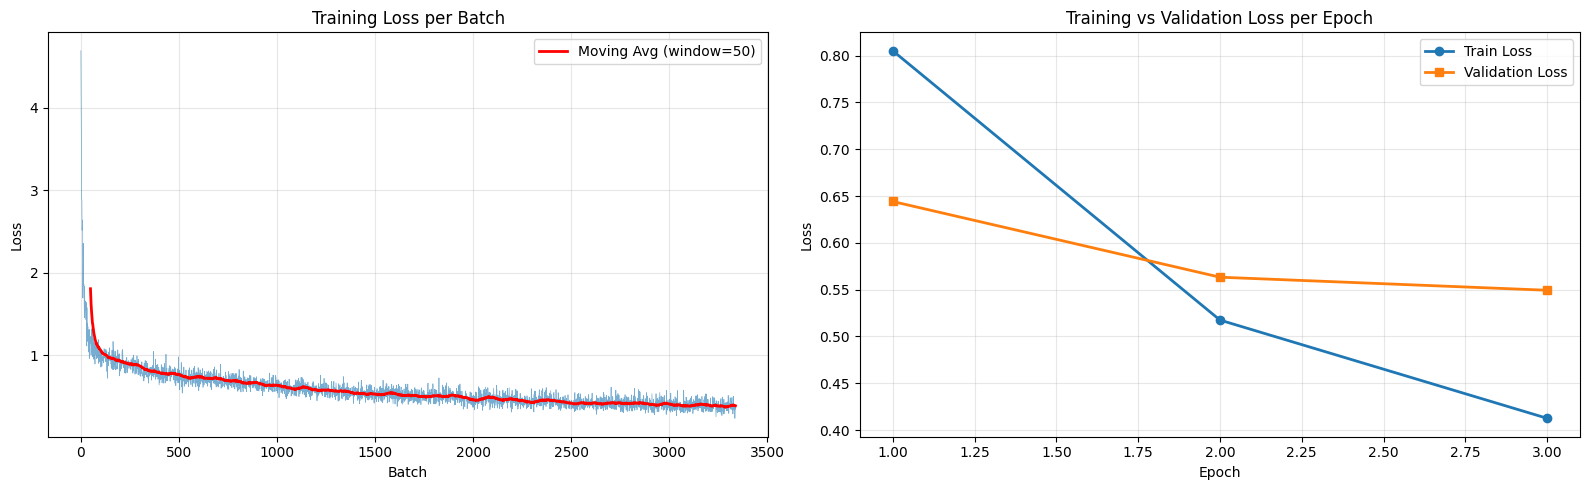


=== Training Summary ===
Total epochs: 3
Total batches: 3339

Final train loss: 0.4125
Final validation loss: 0.5494
Best validation loss: 0.5494 (epoch 3)

Train loss improvement: 0.8052 → 0.4125 (48.8% reduction)
Val loss improvement: 0.6442 → 0.5494 (14.7% reduction)


In [15]:
# Plot training and validation losses
import matplotlib.pyplot as plt
import json

# Load loss history if it exists
try:
    with open('training_loss_history.json', 'r') as f:
        loss_history = json.load(f)
    
    train_batch_losses = loss_history['train_batch_losses']
    train_epoch_losses = loss_history['train_epoch_losses']
    val_epoch_losses = loss_history['val_epoch_losses']
    
    # Create figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Training batch losses
    axes[0].plot(train_batch_losses, alpha=0.6, linewidth=0.5)
    axes[0].set_xlabel('Batch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss per Batch')
    axes[0].grid(True, alpha=0.3)
    
    # Add moving average for smoother visualization
    window_size = min(50, len(train_batch_losses) // 10)
    if window_size > 1:
        moving_avg = np.convolve(train_batch_losses, np.ones(window_size)/window_size, mode='valid')
        axes[0].plot(range(window_size-1, len(train_batch_losses)), moving_avg, 
                    color='red', linewidth=2, label=f'Moving Avg (window={window_size})')
        axes[0].legend()
    
    # Plot 2: Epoch-level losses (train vs validation)
    epochs = range(1, len(train_epoch_losses) + 1)
    axes[1].plot(epochs, train_epoch_losses, marker='o', label='Train Loss', linewidth=2)
    axes[1].plot(epochs, val_epoch_losses, marker='s', label='Validation Loss', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Training vs Validation Loss per Epoch')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_loss_curves.png', dpi=150, bbox_inches='tight')
    print('Loss curves saved to training_loss_curves.png')
    plt.show()
    
    # Print summary statistics
    print('\n=== Training Summary ===')
    print(f'Total epochs: {len(train_epoch_losses)}')
    print(f'Total batches: {len(train_batch_losses)}')
    print(f'\nFinal train loss: {train_epoch_losses[-1]:.4f}')
    print(f'Final validation loss: {val_epoch_losses[-1]:.4f}')
    print(f'Best validation loss: {min(val_epoch_losses):.4f} (epoch {val_epoch_losses.index(min(val_epoch_losses)) + 1})')
    print(f'\nTrain loss improvement: {train_epoch_losses[0]:.4f} → {train_epoch_losses[-1]:.4f} ({((train_epoch_losses[0] - train_epoch_losses[-1]) / train_epoch_losses[0] * 100):.1f}% reduction)')
    print(f'Val loss improvement: {val_epoch_losses[0]:.4f} → {val_epoch_losses[-1]:.4f} ({((val_epoch_losses[0] - val_epoch_losses[-1]) / val_epoch_losses[0] * 100):.1f}% reduction)')
    
except FileNotFoundError:
    print('No training history found. Please run training first (cell 17).')
except Exception as e:
    print(f'Error loading or plotting loss history: {e}')

In [1]:
import numpy as np
np.__version__

'2.2.6'

In [17]:
# Rebuild tokenizer with the improved implementation
if pairs:
    labels = [lab for _, lab in pairs]
    tokenizer = CharTokenizer()  # Create new instance with improved implementation
    tokenizer.build_vocab(labels)
    print('Vocabulary size:', len(tokenizer.vocab))
    print('\nSample tokens from vocabulary:')
    latex_commands = [t for t in tokenizer.vocab.keys() if t.startswith('\\')]
    print('LaTeX commands:', latex_commands[:10], '...' if len(latex_commands) > 10 else '')
    
    print('\nTesting tokenizer with a few examples:')
    test_examples = [
        r'\frac{1}{2}',
        r'\alpha + \beta',
        r'x^2 + y^2',
        pairs[0][1]  # First actual example from dataset
    ]
    
    for example in test_examples:
        print('\nOriginal:', example)
        tokens = tokenizer.encode(example)
        decoded = tokenizer.decode(tokens)
        print('Encoded:', tokens)
        print('Decoded:', decoded)
        print('Matches:', example == decoded)

Vocabulary size: 107

Sample tokens from vocabulary:
LaTeX commands: ['\\', '\\Delta', '\\alpha', '\\beta', '\\cos', '\\div', '\\exists', '\\forall', '\\gamma', '\\geq'] ...

Testing tokenizer with a few examples:

Original: \frac{1}{2}
Encoded: [1, 3, 104, 13, 106, 104, 14, 106, 2]
Decoded: <unk>{1}{2}
Matches: False

Original: \alpha + \beta
Encoded: [1, 45, 4, 8, 4, 46, 2]
Decoded: \alpha + \beta
Matches: True

Original: x^2 + y^2
Encoded: [1, 101, 3, 14, 4, 8, 4, 102, 3, 14, 2]
Decoded: x<unk>2 + y<unk>2
Matches: False

Original: f Sup \prime NoRel ( Right x Right ) Right = NoRel 1 NoRel - Below 2 Right \sqrt Inside x
Encoded: [1, 83, 4, 37, 98, 93, 4, 68, 4, 33, 92, 36, 82, 89, 4, 6, 4, 36, 86, 84, 85, 97, 4, 101, 4, 36, 86, 84, 85, 97, 4, 7, 4, 36, 86, 84, 85, 97, 4, 22, 4, 33, 92, 36, 82, 89, 4, 13, 4, 33, 92, 36, 82, 89, 4, 9, 4, 24, 82, 89, 92, 100, 4, 14, 4, 36, 86, 84, 85, 97, 4, 72, 4, 30, 91, 96, 86, 81, 82, 4, 101, 2]
Decoded: f Sup \prime NoRel ( Right x Right ) Right = 

In [18]:
# Test tokenizer implementation with a simple example
test_latex = r"\frac{1}{2} + \alpha^2"
print("Test string:", test_latex)
print("\nStep by step tokenization:")
print("1. Characters:", [c for c in test_latex])
tokens = tokenizer.encode(test_latex)
print("2. Encoded tokens:", tokens)
decoded = tokenizer.decode(tokens)
print("3. Decoded back:", decoded)
print("\nVerification:")
print("Original == Decoded:", test_latex == decoded)
print("Character-by-character comparison:")
for i, (orig, dec) in enumerate(zip(test_latex, decoded)):
    if orig != dec:
        print(f"Mismatch at position {i}: Original '{orig}' vs Decoded '{dec}'")

Test string: \frac{1}{2} + \alpha^2

Step by step tokenization:
1. Characters: ['\\', 'f', 'r', 'a', 'c', '{', '1', '}', '{', '2', '}', ' ', '+', ' ', '\\', 'a', 'l', 'p', 'h', 'a', '^', '2']
2. Encoded tokens: [1, 3, 104, 13, 106, 104, 14, 106, 4, 8, 4, 45, 3, 14, 2]
3. Decoded back: <unk>{1}{2} + \alpha<unk>2

Verification:
Original == Decoded: False
Character-by-character comparison:
Mismatch at position 0: Original '\' vs Decoded '<'
Mismatch at position 1: Original 'f' vs Decoded 'u'
Mismatch at position 2: Original 'r' vs Decoded 'n'
Mismatch at position 3: Original 'a' vs Decoded 'k'
Mismatch at position 4: Original 'c' vs Decoded '>'
Mismatch at position 20: Original '^' vs Decoded '<'
Mismatch at position 21: Original '2' vs Decoded 'u'


## Test some sample in pix2tex

In [ ]:
%pip install pix2text

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
   ---------------------------------------- 0.0/711.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/711.3 kB ? eta -:--:--
   -------------- ------------------------- 262.1/711.3 kB ? eta -:--:--
   -------------- ------------------------- 262.1/711.3 kB ? eta -:--:--
   ---------------------------- --------- 524.3/711.3 kB 728.2 kB/s eta 0:00:01
   ---------------------------------------- 711.3/711.3 kB 821.1 kB/s  0:00:00
   ---------------------------------------- 0.0/15.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/15.1 MB ? eta -:--:--
    ---------

In [2]:
from pix2text import Pix2Text
p2t = Pix2Text.from_config(device="cpu")

[WARNING 2025-10-22 09:00:28,909 _showwarnmsg:110] d:\projectDAT\image-computer\new_process\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 
[INFO] 2025-10-22 09:00:34,407 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-10-22 09:00:34,412 [RapidOCR] main.py:53: Using C:\Users\Admin\AppData\Roaming\cnstd\1.2\ppocr\ch_PP-OCRv5_det\ch_PP-OCRv5_det_infer.onnx
[INFO] 2025-10-22 09:00:34,407 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-10-22 09:00:34,412 [RapidOCR] main.py:53: Using C:\Users\Admin\AppData\Roaming\cnstd\1.2\ppocr\ch_PP-OCRv5_det\ch_PP-OCRv5_det_infer.onnx
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. Th

In [3]:
from IPython.display import display
from PIL import Image

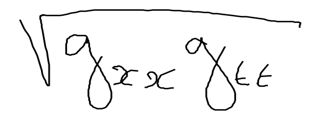

In [15]:
display(Image.open("D:\\projectDAT\\image-computer\\new_process\\Data\\crohme2019\\test\\UN19_1047_em_676.png").convert('RGB').resize((320, 120)))

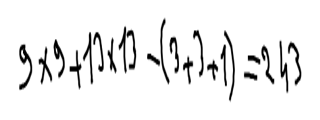


WARNING imgsz=[99, 768] must be multiple of max stride 32, updating to [128, 768]
WARNING imgsz=[99, 768] must be multiple of max stride 32, updating to [128, 768]
0: 128x768 1 isolated, 79.9ms
Speed: 13.0ms preprocess, 79.9ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 768)
0: 128x768 1 isolated, 79.9ms
Speed: 13.0ms preprocess, 79.9ms inference, 1.5ms postprocess per image at shape (1, 3, 128, 768)


100%|██████████| 1/1 [00:00<00:00,  2.34it/s]




$$
9 \times9+1 2 \times1 3-( 3+2+1 )=2 4 3
$$



In [5]:
display(Image.open("D:\\projectDAT\\image-computer\\new_process\\Data\\crohme2019\\test\\UN19wb_1111_em_1039.png").convert('RGB').resize((320, 120)))
result = p2t.recognize(img="D:\\projectDAT\\image-computer\\new_process\\Data\\crohme2019\\test\\UN19wb_1111_em_1039.png", return_text=True)
print(result)

In [ ]:
# Inference: load ViTSeq2Seq checkpoint and recognize any image
import os
import sys
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from transformers import PreTrainedTokenizerFast
import pathlib

# Ensure project root is on sys.path so `new_process.src` imports resolve
proj_root = str(pathlib.Path.cwd().parent)
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

# Adjust these paths
CKPT_PATH = r"C:\Users\Admin\Downloads\vit_seq2seq_test.pt"  # <- your .pt file
TOKENIZER_PATH = r"D:\projectDAT\image-computer\new_process\Data\tokenizer.json"

# Image to recognize (set this to any local image path)
IMAGE_PATH = r""  # e.g., r"D:\projectDAT\image-computer\new_process\Data\crohme2019\test\some.png"

# Setup model
from new_process.src.config import get_args
from new_process.src.model import get_model

args = get_args()
# Prefer available device
args.device = 'cpu'
device = torch.device(args.device)

# Load tokenizer
rf_tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=TOKENIZER_PATH,
    unk_token='[UNK]', pad_token='[PAD]', cls_token='[CLS]', sep_token='[SEP]', mask_token='[MASK]'
)

# Build model
model = get_model(args).to(device)

# Load checkpoint robustly (always map to CPU to avoid CUDA serialization issues)
ck = torch.load(CKPT_PATH, map_location='cpu')
state_dict = None
if isinstance(ck, dict):
    if 'model_state_dict' in ck:
        state_dict = ck['model_state_dict']
    elif 'state_dict' in ck and isinstance(ck['state_dict'], dict):
        state_dict = ck['state_dict']
    elif all(isinstance(k, str) and isinstance(v, torch.Tensor) for k, v in ck.items()):
        state_dict = ck
if state_dict is None:
    raise RuntimeError("Unsupported checkpoint format: could not find model state dict")

# Handle potential 'module.' prefixes (from DataParallel)
new_sd = {}
for k, v in state_dict.items():
    nk = k.replace('module.', '') if k.startswith('module.') else k
    new_sd[nk] = v
missing, unexpected = model.load_state_dict(new_sd, strict=False)
if missing:
    print(f"[load_state_dict] Missing keys: {len(missing)}")
if unexpected:
    print(f"[load_state_dict] Unexpected keys: {len(unexpected)}")
model = model.to(device).eval()

# Preprocess image (grayscale, keep aspect <= max dims, pad with white)
def preprocess_image(path, args):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Cannot read image: {path}")
    h, w = img.shape[:2]
    max_h = getattr(args, 'max_height', 64)
    max_w = getattr(args, 'max_width', 256)

    # Scale to fit within max dims (keep aspect)
    scale = min(max_w / w, max_h / h, 1.0)
    new_w = max(1, int(round(w * scale)))
    new_h = max(1, int(round(h * scale)))
    if new_w != w or new_h != h:
        img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Ensure dims are multiples of patch size
    ps = getattr(args, 'patch_size', 1)
    pad_h = (-(img.shape[0]) % ps) if (img.shape[0] % ps) != 0 else 0
    pad_w = (-(img.shape[1]) % ps) if (img.shape[1] % ps) != 0 else 0

    # Pad with white (255)
    if pad_h != 0 or pad_w != 0:
        img = np.pad(img, ((0, pad_h), (0, pad_w)), mode='constant', constant_values=255)

    # Normalize to [0,1], add channel and batch dims
    tens = torch.from_numpy(img.astype('float32') / 255.0).unsqueeze(0).unsqueeze(0)
    return tens

# Decode helper
def decode_tokens(tokenizer, ids):
    toks = [t for t in ids if t != tokenizer.pad_token_id]
    return tokenizer.decode(toks, skip_special_tokens=True)

# Run inference if path provided
if IMAGE_PATH:
    with torch.no_grad():
        x = preprocess_image(IMAGE_PATH, args).to(device)
        preds = model.generate(x)  # BxT
        pred_text = decode_tokens(rf_tokenizer, preds[0].tolist())
    print("Input:", IMAGE_PATH)
    print("Prediction:", pred_text)
else:
    print("Set IMAGE_PATH to a valid image file to run recognition.")

[load_state_dict] Missing keys: 111
[load_state_dict] Unexpected keys: 434


RuntimeError: [enforce fail at alloc_cpu.cpp:121] data. DefaultCPUAllocator: not enough memory: you tried to allocate 234356682816 bytes.

In [7]:
import requests
import base64

def image_to_hex(image_path: str) -> str:
    """Đọc ảnh và chuyển sang chuỗi hex."""
    with open(image_path, "rb") as f:
        return f.read().hex()

def send_request(image_path: str, prompt: str, server_url="https://8000-01k91mnws2kffssyc1aytwn85r.cloudspaces.litng.ai/predict"):
    # Chuyển ảnh sang hex
    image_hex = image_to_hex(image_path)

    # Payload JSON gửi đến API
    payload = {
        "image_bytes": image_hex,
        "prompt": prompt
    }

    # Gửi POST request
    response = requests.post(server_url, json=payload)

    # Kiểm tra kết quả
    if response.status_code == 200:
        print("✅ Response from server:")
        print(response.text)
    else:
        print(f"❌ Error {response.status_code}: {response.text}")

if __name__ == "__main__":
    # --- ví dụ sử dụng ---
    image_path = "D:\\projectDAT\\image-computer\\new_process\\Data\\crohme2019\\test\\ISICal19_1201_em_750.png"  # thay bằng đường dẫn ảnh của bạn
    prompt = "Describe the content of this image in detail."

    send_request(image_path, prompt)


✅ Response from server:
"user\nDescribe the content of this image in detail.\nassistant\nThis is a handwritten mathematical expression. It consists of a single right - right \\div right 1 Right 9 Right 2 NoRel 1 NoRel. The expression is read as “minus one divided by 192.” The numerator is the digit 1. The denominator is the number 192. The minus sign is to the left of the division symbol. No other symbols or labels are present."
